<a href="https://colab.research.google.com/github/raihansulaiman/data-analytics/blob/main/CNN_CardsImage/CNN_CardsImage_RaihanSulaiman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification Model Deployment
**Created by Raihan Sulaiman (1494037162101-989)**

The objectives of model:


*   The dataset must be divided into a train set and a validation set. The validation set size must be 20% of the total dataset (training data has  samples, and validation data has  samples).
*   Model must uses Conv2D Maxpooling Layer.
*   The accuracy of the model is at least 80%.
*   Model is saved in TF-Lite format.



Interact with Kaggle

In [ ]:
# Install kaggle package
!pip install -q kaggle

# Upload kaggle's beta API to interact with kaggle's dataset
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"raihansulaiman","key":"f61fee8e970bda8070b5e9adcf131c1f"}'}

Download and Manage Kaggle Dataset Directories



In [ ]:
# Create directory and change file permission
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

# Download dataset
!kaggle datasets download -d gpiosenka/cards-image-datasetclassification

import zipfile
zipPath = '../content/cards-image-datasetclassification.zip'
zipFile = zipfile.ZipFile(zipPath, 'r')
zipFile.extractall('../content/cards-image-datasetclassification/')
zipFile.close()

kaggle.json
cards-image-datasetclassification.zip: Skipping, found more recently modified local copy (use --force to force download)


Import Necessary Modules

In [ ]:
import pandas as pd
import numpy as np
import os
import pathlib
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from pathlib import Path
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping

Create train and validation dataset generator for image augmentation

In [ ]:
base_dir = pd.read_csv('../content/cards-image-datasetclassification/cards.csv')
train_dir = Path('../content/cards-image-datasetclassification/train/')
test_dir = image_dataset_from_directory('../content/cards-image-datasetclassification/test/')
Class_names = test_dir.class_names
print(Class_names)

Found 265 files belonging to 53 classes.
['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'joker', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three of hearts', 'three of spades', 'two of clubs', 'two of diamonds', 'two of hearts', 'two of spades']


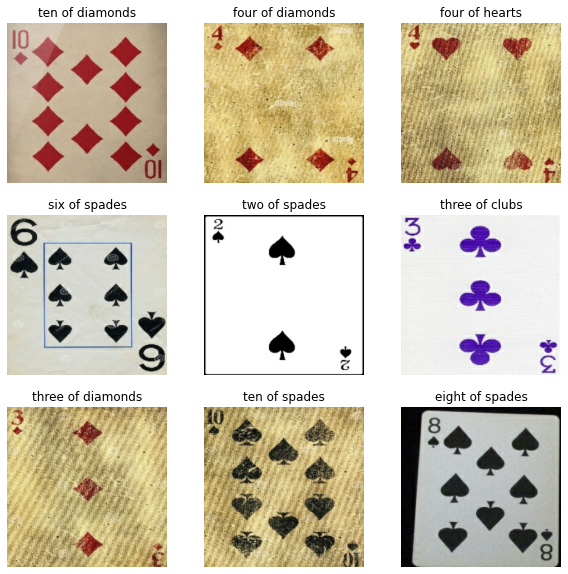

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in test_dir.take(1):
    for i in range(9):
        ax=plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(Class_names[labels[i]])
        plt.axis("off")
plt.show()

In [ ]:
# Validation set is 20%
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = 'nearest',
    validation_split = 0.2
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split = 0.2
)

IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 64
     
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True,
    subset = "training"
)

validation_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True,
    subset = "validation"
)

train_num = train_generator.samples
validation_num = validation_generator.samples 

Found 6121 images belonging to 53 classes.
Found 1503 images belonging to 53 classes.


Create and compile model

In [ ]:
model = Sequential([
     tf.keras.layers.Conv2D(16, (3,3), activation = 'relu' , input_shape = (150,150,3)),
     tf.keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'same'),
     tf.keras.layers.Conv2D(32, (3,3), activation = 'relu' ),
     tf.keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'same'),
     tf.keras.layers.Conv2D(64, (3,3), activation = 'relu' ),
     tf.keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'same'),
     tf.keras.layers.Conv2D(128, (3,3), activation = 'relu' ),
     tf.keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'same'),
     tf.keras.layers.Conv2D(256, (3,3), activation = 'relu'),
     tf.keras.layers.MaxPooling2D(pool_size = (2,2), padding = 'same'),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation = 'relu'),
     tf.keras.layers.Dense(53, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

Train Model

In [ ]:
# Monitor Validation Loss using callback
class MyCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.80 and logs.get('val_accuracy') >= 0.80):
      print("\nAccuracy and Validation Accuracy has reached 80%!\nStop Train!")
      self.model.stop_training = True
callback = MyCallback()

# Train Model
history = model.fit_generator(
    train_generator,
    validation_data = validation_generator,
    epochs = 100,
    callbacks = callback
)

<ipython-input-13-c0cc12976b9d>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
96/96 [==============================] - 51s 494ms/step - loss: 3.7406 - accuracy: 0.0673 - val_loss: 2.8871 - val_accuracy: 0.1677
Epoch 2/100
96/96 [==============================] - 38s 401ms/step - loss: 2.7409 - accuracy: 0.2452 - val_loss: 2.2104 - val_accuracy: 0.3353
Epoch 3/100
96/96 [==============================] - 38s 396ms/step - loss: 2.3201 - accuracy: 0.3382 - val_loss: 1.7771 - val_accuracy: 0.4385
Epoch 4/100
96/96 [==============================] - 37s 383ms/step - loss: 2.0609 - accuracy: 0.4166 - val_loss: 1.5197 - val_accuracy: 0.5289
Epoch 5/100
96/96 [==============================] - 37s 386ms/step - loss: 1.8630 - accuracy: 0.4829 - val_loss: 1.3381 - val_accuracy: 0.5968
Epoch 6/100
96/96 [==============================] - 37s 382ms/step - loss: 1.6869 - accuracy: 0.5368 - val_loss: 1.1600 - val_accuracy: 0.6813
Epoch 7/100
96/96 [==============================] - 37s 384ms/step - loss: 1.5693 - accuracy: 0.5700 - val_loss: 1.0862 - val_accuracy:

Evaluate the accuracy and loss of model

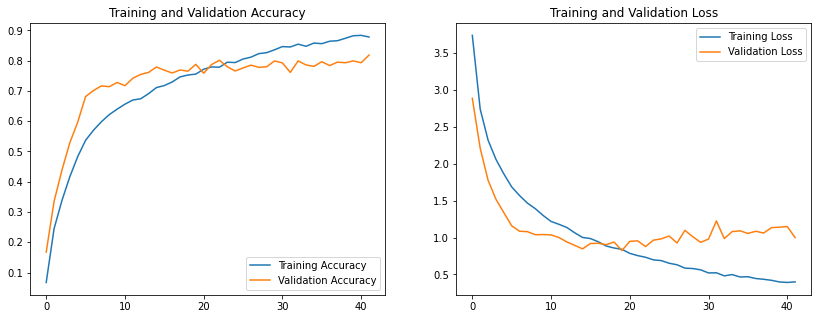

In [ ]:
plt.figure(figsize=(14, 5))

# Accuracy of Model
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss of Model
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.savefig('./foo.png')
plt.show()

Save model in TF-Lite format

In [ ]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('CardsImage.tflite')
tflite_model_file.write_bytes(tflite_model)
     

2783208